In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gurobipy import *
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
import collections
import cvxpy as cp

## Estimation Models

In [94]:
## linear regression
def linear_regress(Xs, Rs, reg):
    X_train, R_train = [], []
    for j in range(J):
        tmp = np.concatenate((Xs[j], np.zeros((len(Xs[j]), (d+1) * (J-1)))), axis=1)
        if j >= 1:
            for n in range(len(Rs[j])):
                tmp[n][d + (j-1) * (d+1)] = 1
                tmp[n][d + (j-1) * (d+1) + 1: d + j * (d+1)] = Xs[j][n]
        
        X_train.append(tmp)
        R_train.append(Rs[j])
    
    X_trains = np.concatenate(X_train)
    R_trains = np.concatenate(R_train)
    
    if reg == 'ordinal':
        lr, cv_loss = ols(X_train, R_train)
        return lr.intercept_, lr.coef_, cv_loss
    elif reg == 'ridge':
        m = linear_model.RidgeCV(cv=10)
        lr = m.fit(X_trains, R_trains)
    elif reg == 'lasso':
        m = linear_model.LassoCV(cv=10)
        lr = m.fit(X_trains, R_trains)  
    elif reg == 'new':
        res, cv_loss = new(X_train, R_train)
        
        return res[0], res[1:], cv_loss
        
    return lr.intercept_, lr.coef_

In [122]:
def new(X_train, R_train): 
    F = 10
    p = (0, 0.5, 0.5)
    
    X_train_0 = np.concatenate((np.reshape(np.ones(len(X_train[0])), (-1, 1)), X_train[0]), axis=1)
    X_train_1 = np.concatenate((np.reshape(np.ones(len(X_train[1])), (-1, 1)), X_train[1]), axis=1)
    X_train_2 = np.concatenate((np.reshape(np.ones(len(X_train[2])), (-1, 1)), X_train[2]), axis=1)
    
    X_fold = {0: np.split(X_train_0, 10), 1: np.split(X_train_1, 10), 2: np.split(X_train_2, 10)}
    R_fold = {0: np.split(R_train[0], 10), 1: np.split(R_train[1], 10), 2: np.split(R_train[2], 10)}
    
#     coefs = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2]
    coefs = [0, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 30]
    coefs_loss = []
    for coef in coefs:  
        Loss = 0
        for k in range(F):
            R_valid = np.concatenate([R_fold[j][k] for j in range(J)])
            X_valid = np.concatenate([X_fold[j][k] for j in range(J)])

            R_input = np.concatenate([R_fold[j][l] for j in range(J) for l in range(F) if l != k])
            X_input = np.concatenate([X_fold[j][l] for j in range(J) for l in range(F) if l != k])

            beta = solve_convex(X_input, R_input, coef, p)

            loss = np.sum((np.dot(X_valid, beta) - R_valid) ** 2)
            Loss += loss
        coefs_loss.append(Loss/(J * N))
    
    cv_coef = coefs[np.argmin(coefs_loss)]
    cv_loss = np.min(coefs_loss) 
    print(cv_coef)
    print(coefs_loss)
    beta = solve_convex(np.concatenate([X_train_0, X_train_1, X_train_2]), np.concatenate(R_train), cv_coef, p)

    return beta, coefs_loss

In [72]:
def ols(X_train, R_train): 
    F = 10
    X_fold = {0: np.split(X_train[0], F), 1: np.split(X_train[1], F), 2: np.split(X_train[2], F)}
    R_fold = {0: np.split(R_train[0], F), 1: np.split(R_train[1], F), 2: np.split(R_train[2], F)}

    Loss = 0
    for k in range(F):
        R_valid = np.concatenate([R_fold[j][k] for j in range(J)])
        X_valid = np.concatenate([X_fold[j][k] for j in range(J)])

        R_input = np.concatenate([R_fold[j][l] for j in range(J) for l in range(F) if l != k])
        X_input = np.concatenate([X_fold[j][l] for j in range(J) for l in range(F) if l != k])

        lr = linear_model.LinearRegression().fit(X_input, R_input) 
        loss = np.sum((lr.intercept_ + np.dot(X_valid, lr.coef_) - R_valid) ** 2)
        Loss += loss
    
    m = linear_model.LinearRegression()
    lr = m.fit(np.concatenate(X_train), np.concatenate(R_train))
    cv_loss = Loss / (J * N)
    print(cv_loss)
    return lr, cv_loss

In [61]:
def solve_convex(X_input, R_input, _lambda, _prob):
    beta = cp.Variable((d + 1) * J)
    loss = cp.sum_squares(X_input @ beta - R_input) / len(R_input)
    
    regularizer = 0
    for j in range(J):
#         if j >= 1:
#             for i in range(d):
#                 regularizer += (sigma[i] * (beta[i+1+j*(d+1)])) ** 2 * _prob[j]        
        
        if j >= 1:
            regularizer += cp.quad_form(beta[1+j*(d+1):(j+1)*(d+1)], Sigma) * _prob[j]    
    
#         if j == 0:
#             for i in range(d):
#                 regularizer += (sigma[i] * beta[i+1]) ** 2 * _prob[j]
#         elif j >= 1:
#             for i in range(d):
#                 regularizer += (sigma[i] * (beta[i+1] + beta[i+1+j*(d+1)])) ** 2 * _prob[j]
        
#         if j == 0:
#             regularizer += cp.quad_form(beta[1:d+1], Sigma) * _prob[j]
#         else:
#             regularizer += cp.quad_form(beta[1:d+1] + beta[1+j*(d+1):(j+1)*(d+1)], Sigma) * _prob[j]
           
                
    prob = cp.Problem(cp.Minimize(loss + regularizer * _lambda))
    prob.solve()
    
    return beta.value

## Optimization Models

In [18]:
def inner_opt_soc(Z, Gamma, gamma):
    m = Model()
    m.setParam('LogToConsole', 0)
    
    Beta_0 = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Beta_1 = m.addVars(((j, i) for j in range(J) for i in range(d)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Delta = m.addVars(((j, n) for j in range(J) for n in range(len(Xs[j]))), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    
    m.setObjective(sum([Z[j, k] * (Beta_0[j] + sum(Beta_1[j, i] * XC[k, i] for i in range(d))) for j in range(J) for k in range(K)]), GRB.MINIMIZE)
    
    for j in range(J):
        m.addConstr(Beta_0[j] + sum([Beta_1[j, i] * mu[i] for i in range(d)]) >= marginal_estimation[j])
        
    for j in range(J):
        for n in range(len(Xs[j])):
            m.addConstr(Delta[j, n] == Beta_0[j] + sum([Beta_1[j, i] * Xs[j][n, i] for i in range(d)]) - Rs[j][n])
    
    m.addConstr(sum([Delta[j, n] ** 2 for j in range(J) for n in range(len(Xs[j]))]) <= Gamma ** 2)
    
    for j in range(J):
        m.addConstr(sum([(Beta_1[j, i] * X_std[i]) ** 2 for i in range(d)]) <= gamma[j] ** 2)
        
    m.optimize()
    sol = m.getAttr('X', Beta_1)
    print(sol)

In [19]:
def robust_opt_soc(X_new, Gamma, gamma):
    m = Model()
    m.setParam('LogToConsole', 0)
    m.setParam('BarHomogeneous', 1)
    m.setParam('Method', 2)
    m.setParam('MIPGap', 0.01)
    
    Z = m.addVars(((j, k) for k in range(K) for j in range(J)), vtype=GRB.BINARY, lb=0, ub=1)
    Lambda = m.addVars((0,), vtype=GRB.CONTINUOUS, lb=0)
    Theta = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    Nu = m.addVars(((j, n) for j in range(J) for n in range(len(Xs[j]))), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    _lambda = m.addVars((j for j in range(J)), vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY)
    alpha = m.addVars(((j, i) for j in range(J) for i in range(d)), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY)
    
    marginal_gain = sum([Theta[j] * mean_estimation[j] for j in range(J)])
    estimate_gain = sum([Rs[j][n] * Nu[j, n] for j in range(J) for n in range(len(Xs[j]))])
    bias_loss = Gamma * Lambda[0]
    local_loss = sum([gamma[j] * _lambda[j] for j in range(J)])
    
    m.setObjective(marginal_gain + estimate_gain - bias_loss - local_loss, GRB.MAXIMIZE)
  
    ## part 0
    m.addConstr(sum(Theta[j] for j in range(J)) + sum([Nu[j, n] for j in range(J) for n in range(len(Xs[j]))]) == sum([Z[j, k] for j in range(J) for k in range(K)]))
    for j in range(1, J):
        m.addConstr(Theta[j] + sum([Nu[j, n] for n in range(len(Xs[j]))]) == sum([Z[j, k] for k in range(K)]))

    ## part 1
    for i in range(d):
        m.addConstr(sum(Theta[j] * mu[i] for j in range(J)) + sum(Nu[j, n] * Xs[j][n, i] for j in range(J) for n in range(len(Xs[j]))) + sum(alpha[j, i] * sigma[i] for j in range(J)) == sum([Z[j, k] * X_new[k][i] for j in range(J) for k in range(K)]))
        for j in range(1, J):
            m.addConstr(Theta[j] * mu[i] + sum(Nu[j, n] * Xs[j][n, i] for n in range(len(Xs[j]))) + alpha[j, i] * sigma[i] == sum([Z[j, k] * X_new[k][i] for k in range(K)]))

    ## part 2
    m.addConstr(sum([Nu[j, n] ** 2 for j in range(J) for n in range(len(Xs[j]))]) <= Lambda[0] ** 2)
    
    for j in range(J):
        m.addConstr(sum([alpha[j, i] ** 2 for i in range(d)]) <= _lambda[j] ** 2)
        
    m.addConstr(Lambda[0] <= 1000)   
    for j in range(J):
        m.addConstr(_lambda[j] <= 1000)   
        
    for k in range(K):
        m.addConstr(sum([Z[j, k] for j in range(J)]) == 1)
        
#     m.addConstr(sum(Z[1, k] for k in range(K)) <= 0.3 * K)
#     m.addConstr(sum(Z[2, k] for k in range(K)) <= 0.3 * K)
        

    m.addConstr(Lambda[0] == 0)

    m.optimize()
    
    policy = ['NA'] * K
    sol = m.getAttr('X', Z)
    obj = m.objVal
    for j, k in sol:
        if sol[j, k] > 0.9:
             policy[k] = j
    
    return policy, obj

In [20]:
def det_opt(Phi):
    m = Model()
    m.setParam('LogToConsole', 0)
    m.setParam('BarHomogeneous', 1)
    m.setParam('Method', 2)
    
    Z = m.addVars(((j, k) for k in range(K) for j in range(J)), vtype=GRB.BINARY, lb=0, ub=1)
  
    m.setObjective(sum([Z[j, k] * Phi[j, k] for j in range(J) for k in range(K)]), GRB.MAXIMIZE)
  
    for k in range(K):
        m.addConstr(sum([Z[j, k] for j in range(J)]) == 1)
        
#     m.addConstr(sum(Z[1, k] for k in range(K)) <= 0.3 * K)
#     m.addConstr(sum(Z[2, k] for k in range(K)) <= 0.3 * K)
   
    m.optimize()
    
    policy = ['NA'] * K
    sol = m.getAttr('X', Z)
    obj = m.objVal
    for j, k in sol:
        if sol[j, k] > 0.99:
             policy[k] = j
    
    return policy, obj

In [21]:
data_raw_neigh = pd.read_csv('../Data/Social/ProcessedData/socialpresswgeooneperhh_NEIGH.csv')
data_raw_self = pd.read_csv('../Data/Social/ProcessedData/socialpresswgeooneperhh_SELF.csv')

In [22]:
J = 3

In [23]:
data_raw = pd.concat((data_raw_neigh, data_raw_self.loc[data_raw_self['treat_self'] == 1]))
data_raw = data_raw.rename(columns={'outcome_voted': 'Y', "treat_neighbors" : 'W1', "treat_self": 'W2'})

In [24]:
cts_variables_names = ["yob", "hh_size", "totalpopulation_estimate",
                      "percent_male", "median_age", "percent_62yearsandover",
                      "percent_white", "percent_black", "percent_asian", "median_income",
                      "employ_20to64", "highschool", "bach_orhigher","percent_hispanicorlatino"]

binary_variables_names = ["sex", "g2000", "g2002", "p2000", "p2002", "p2004"]

causal_names = ["Y", "W1", "W2"]

In [25]:
data_raw = data_raw.dropna()
data_new = data_raw[cts_variables_names + binary_variables_names + causal_names] 

In [26]:
# cts_variables_mean = data_raw[cts_variables_names].mean()
# cts_variables_std = data_raw[cts_variables_names].std()
# data_new = (data_raw[cts_variables_names] - cts_variables_mean) / cts_variables_std

In [27]:
data_train_pool_0 = data_new.loc[(data_new['W1'] == 0) & (data_new['W2'] == 0)][:10000]
data_train_pool_1 = data_new.loc[data_new['W1'] == 1][:10000]
data_train_pool_2 = data_new.loc[data_new['W2'] == 1][:10000]

data_test_0 = data_new.loc[(data_new['W1'] == 0) & (data_new['W2'] == 0)][10000:20000]
data_test_1 = data_new.loc[data_new['W1'] == 1][10000:20000]
data_test_2 = data_new.loc[data_new['W2'] == 1][10000:20000]
data_test = pd.concat((data_test_0, data_test_1, data_test_2))
# data_test = pd.concat((data_test_0, data_test_1))

cts_variables_mean = data_test[cts_variables_names].mean()
cts_variables_std = data_test[cts_variables_names].std()
data_test[cts_variables_names] = (data_test[cts_variables_names] - cts_variables_mean) / cts_variables_std

In [31]:
def generate_samples(N, seed):
    np.random.seed(seed)
    data_train_0 = data_train_pool_0.sample(n=N)
    data_train_1 = data_train_pool_1.sample(n=N)
    data_train_2 = data_train_pool_2.sample(n=N)
    data_train = pd.concat((data_train_0, data_train_1, data_train_2))
#     data_train = pd.concat((data_train_0, data_train_1))
    
    cts_variables_mean = data_train[cts_variables_names].mean()
    cts_variables_std = data_train[cts_variables_names].std()
    data_train[cts_variables_names] = (data_train[cts_variables_names] - cts_variables_mean) / cts_variables_std
    
    Xs = []
    Rs = []
    for j in range(J):
        if j == 0:
            data_train_0[cts_variables_names] = (data_train_0[cts_variables_names] - cts_variables_mean) / cts_variables_std
            X = data_train_0[cts_variables_names + binary_variables_names].to_numpy()
            Xs.append(X)
            Y = data_train_0['Y'].to_numpy()
            Rs.append(Y)
        if j == 1:
            data_train_1[cts_variables_names] = (data_train_1[cts_variables_names] - cts_variables_mean) / cts_variables_std
            X = data_train_1[cts_variables_names + binary_variables_names].to_numpy()
            Xs.append(X)
            Y = data_train_1['Y'].to_numpy()
            Rs.append(Y)
        if j == 2:
            data_train_2[cts_variables_names] = (data_train_2[cts_variables_names] - cts_variables_mean) / cts_variables_std
            X = data_train_2[cts_variables_names + binary_variables_names].to_numpy()
            Xs.append(X)
            Y = data_train_2['Y'].to_numpy()
            Rs.append(Y)
            
    mu = data_train[cts_variables_names + binary_variables_names].mean().to_numpy()
    sigma = data_train[cts_variables_names + binary_variables_names].std().to_numpy()
    Sigma = data_train[cts_variables_names + binary_variables_names].cov().to_numpy()
    
    propensity = [len(data_test_0)/len(data_test), len(data_test_1)/len(data_test), len(data_test_2)/len(data_test)]
    
    return Xs, Rs, mu, sigma, Sigma, propensity

In [33]:
## moment information
def estimate_moments():
    mean_estimation = []
    for j in range(J):
        if j == 0:
            ave_effect = hat_beta_share_0 + np.dot(mu, hat_beta_share_1) 
        if j >= 1:
            ave_effect = hat_beta_share_0 + hat_beta_0[j-1] + np.dot(mu, (hat_beta_share_1 + hat_beta_1[j-1])) 

#         ave_effect = np.mean(Rs[j])
        
        mean_estimation.append(ave_effect)
        
    std_estimation = []
    for j in range(J):
        var = 0
        for i in range(d):
#             if j == 0:
#                 tmp = hat_beta_share_1[i] * sigma[i]
#             if j >= 1:
#                 tmp = (hat_beta_share_1[i] + hat_beta_1[j-1][i]) * sigma[i]
#             var += (tmp ** 2)
            if j == 0:
                tmp = hat_beta_share_1
                var = np.dot(np.dot(tmp.T, Sigma), tmp)
            else:
                tmp = hat_beta_share_1 + hat_beta_1[j-1]
                var = np.dot(np.dot(tmp.T, Sigma), tmp)
            
        std_estimation.append(np.sqrt(var))

    std_estimation = np.array(std_estimation)
    
    return mean_estimation, std_estimation

In [120]:
## training
def prediction(method):
    hat_beta_share_0, params, coefs_loss = linear_regress(Xs, Rs, method)

    hat_beta_0, hat_beta_1 = [], []
    hat_beta_share_1 = params[:d]

    for j in range(1, J):
        hat_beta_0.append(params[d + (j-1) * (d+1)])
        hat_beta_1.append(params[d + (j-1) * (d+1) + 1: d + j * (d+1)])

#     hat_Rs = []
#     for j in range(J):
#         hat_R = []
#         for n in range(len(Xs[j])):
#             hat_R_n = hat_beta_share_0 + np.dot(Xs[j][n], hat_beta_share_1)   
#             if j >= 1:
#                 hat_R_n += (hat_beta_0[j-1] + np.dot(Xs[j][n], hat_beta_1[j-1]))
#             hat_R.append(hat_R_n)
#         hat_Rs.append(hat_R)
#     hat_Rs = np.array(hat_Rs)
    
#     loss = 0
#     for j in range(J):
#         loss += np.sum((Rs[j] - hat_Rs[j]) ** 2)
    
    return hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, coefs_loss

In [36]:
## testing
def prescription():
    gamma = variance_estimation
    Gamma = np.sqrt(loss * r)

    stats = []
    policy_dis = [collections.defaultdict(int), collections.defaultdict(int)]
    np.random.seed(1)
    for b in range(int(len(data_test) / K)):
        Xc, Rc, Wc = [], [], []
        for i in range(b * K, (b + 1) * K):
            row = data_test.iloc[i]
            Xc.append(row[cts_variables_names + binary_variables_names])
            Rc.append(row['Y'])
            if row['W1'] == 1:
                Wc.append(1)
            elif row['W2'] == 1:
                Wc.append(2)
            else:
                Wc.append(0)

        if r > 1:
            policy_robust, obj = robust(Xc, Gamma, gamma)
            if obj >= 3000:
                print('error')
        policy_lr, obj = greedy(Xc)

        rewards_robust, rewards_lr = 0, 0
        for k in range(K):
            if r > 1:
                W_k = policy_robust[k]
                policy_dis[0][W_k] += 1
                if W_k == Wc[k]:
                    rewards_robust += (Rc[k] / propensity[int(Wc[k])])

            W_k = policy_lr[k]
            policy_dis[1][W_k] += 1
            if W_k == Wc[k]:
                rewards_lr += (Rc[k] / propensity[int(Wc[k])])

        stats.append([rewards_robust, rewards_lr])
        
    return stats, policy_dis

## Some Benchmarks

In [37]:
def greedy(Xc):
    Phi = {}
    for k in range(K):
        for j in range(J):
            Yc_pred = hat_beta_share_0 + np.dot(Xc[k], hat_beta_share_1)
            if j >= 1:
                Yc_pred += (hat_beta_0[j-1] + np.dot(Xc[k], hat_beta_1[j-1]))
            Phi[j, k] = Yc_pred

    policy_lr, obj = det_opt(Phi)
                
    return policy_lr, obj

def optimal(Xc):      
    Phi = {}
    for k in range(K):
        for j in range(J):
            Yc_pred = beta_share_0 + np.dot(Xc[k], beta_share_1)
            if j >= 1:
                Yc_pred += (beta_0[j-1] + np.dot(Xc[k], beta_1[j-1]))
            Phi[j, k] = Yc_pred

    policy_opt, obj = det_opt(Phi)
   
    return policy_opt   

def robust(Xc, Gamma, gamma):
    #policy_robust, sol = robust_opt(Gamma)
    policy_robust, obj = robust_opt_soc(Xc, Gamma, gamma)
    
    return policy_robust, obj

## Main

In [38]:
K = 1000
d = len(cts_variables_names) + len(binary_variables_names)

In [131]:
output = {}

for N in [400]:
    for reg in ['ordinal']:
        performance, predict_loss = [], []
        for seed in range(1):
            print('Estimation: ' + str(reg) + ', Number of samples per treatment: ' + str(N) + ', Seed: ' + str(seed))
            Xs, Rs, mu, sigma, Sigma, propensity = generate_samples(N, seed)
            hat_beta_share_0, hat_beta_share_1, hat_beta_0, hat_beta_1, coefs_loss = prediction(reg)
            mean_estimation, variance_estimation = estimate_moments()
#             print(mean_estimation)
#             print(variance_estimation)
#             print(hat_beta_1)
            
            if reg == 'ordinal':
                r = 1
            else:
                r = 1
            stats, policy_dis = prescription()
            
            res = np.mean(stats, axis=0) / K
            print(res)
            performance.append([res[0], res[1], max(res[0], res[1])])
            predict_loss.append(coefs_loss)

        output[N, reg] = performance

Estimation: ordinal, Number of samples per treatment: 400, Seed: 0
0.22306245258500193
[0.     0.3286]


In [144]:
np.dot(Xs[1], hat_beta_1[0])[:10] + hat_beta_0[0] - (np.dot(Xs[1], hat_beta_1[1])[:10] + hat_beta_0[1])

array([ 0.16914545, -0.44469787,  0.12785938, -0.01526492,  0.00999671,
        0.17633822,  0.07029145, -0.07152893,  0.05589052,  0.02201346])

In [143]:
np.dot(Xs[1], hat_beta_1[1])[:10] + hat_beta_0[1]

array([-0.05356523,  0.67286614, -0.06504211,  0.37791125, -0.09256835,
       -0.16778696, -0.19443507,  0.08935329, -0.05819374, -0.01398199])

In [141]:
np.dot(Xs[1], hat_beta_share_1)[:10]

array([ 0.04385579,  0.07674032, -0.19366902,  0.25926723,  0.16030753,
        0.20829929,  0.41353323,  0.25481849, -0.03864874,  0.3229477 ])

In [148]:
np.round(Xs[1][0] * hat_beta_1[1], 2)

array([ 0.  , -0.01, -0.  ,  0.06,  0.06, -0.03, -0.06,  0.01,  0.01,
       -0.17, -0.  , -0.06,  0.12,  0.01,  0.  , -0.01,  0.06, -0.  ,
       -0.02,  0.  ])

In [151]:
np.round(Xs[1][1] * hat_beta_1[1], 2)

array([-0.  , -0.01,  0.  ,  0.08,  0.25, -0.01,  0.07,  0.05, -0.  ,
       -0.02,  0.03, -0.11,  0.25,  0.  ,  0.06, -0.  ,  0.06, -0.  ,
       -0.  ,  0.01])

In [152]:
np.round(Xs[1][2] * hat_beta_1[1], 2)

array([ 0.  ,  0.16, -0.  , -0.11,  0.32, -0.26, -0.13,  0.06,  0.  ,
       -0.15,  0.02, -0.05,  0.14, -0.03,  0.  , -0.01,  0.  , -0.  ,
       -0.  ,  0.  ])

In [117]:
for reg in ['new']:
    ave, std = [], []
    for N in [1000]:
        ave.append(np.round(np.mean(output[N, reg], axis=0), 3))
        std.append(np.round(np.std(output[N, reg], axis=0), 3))
    
    print(ave)
    print(std)
    print('---------')

[array([0.   , 0.395, 0.395])]
[array([0.   , 0.007, 0.007])]
---------


In [128]:
predict_loss[-1]

[0.21033974846151784,
 0.2045690525646315,
 0.20406218118372565,
 0.2040151306404678,
 0.20399770470721523,
 0.20399656502463415,
 0.20400452881424638,
 0.20401754891506388,
 0.20410221888823823,
 0.20417803973383072,
 0.20423744192267773,
 0.20428378674692896,
 0.20432053958677437,
 0.20435024673885338,
 0.2043746912612071,
 0.204395126040309,
 0.20449749571448775,
 0.204535708603932]

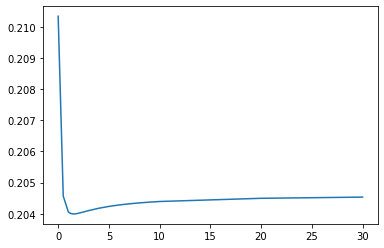

In [129]:
x = [0, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 30]
y = predict_loss[-1]
plt.plot(x, y)